In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
from sklearn.metrics import r2_score
import diversity_tools as dt

In [6]:
selected_cbg_brand = pd.read_csv('selected_cbg_brand.csv', index_col = 'cbg')
selected_brands = pd.read_csv('selected_brands.csv')
selected_cbg_stats = pd.read_csv('selected_cbg_stats.csv', index_col = 'cbg')
brand_cat = pd.read_csv('brand_cat.csv')
brand_median = pd.read_csv('brand_median.csv')
yelp_labelled = pd.read_csv('yelp_labelled.csv')
cbg_diversity = pd.read_csv('cbg_diversity.csv', index_col = 'cbg')
selected_cbg_edu = selected_cbg_stats[['bachelor_or_higher', 'years_edu_weighted']]

In [7]:
edu_diversity = pd.merge(selected_cbg_edu, cbg_diversity, left_index = True, right_index = True)

In [8]:
edu_diversity.corr()

,bachelor_or_higher,years_edu_weighted,nbrands,entropy_brand,brand_range,brand_std,nlevels,entropy_price
bachelor_or_higher,1.000000,0.891559,0.109938,0.133049,0.282869,0.380649,0.261270,0.390420
years_edu_weighted,0.891559,1.000000,0.093875,0.086471,0.174742,0.260215,0.156939,0.243013
nbrands,0.109938,0.093875,1.000000,0.917581,0.506771,0.320851,0.459152,0.261507
entropy_brand,0.133049,0.086471,0.917581,1.000000,0.543204,0.397912,0.492515,0.368576
brand_range,0.282869,0.174742,0.506771,0.543204,1.000000,0.808878,0.398483,0.408624
brand_std,0.380649,0.260215,0.320851,0.397912,0.808878,1.000000,0.362718,0.465947
nlevels,0.261270,0.156939,0.459152,0.492515,0.398483,0.362718,1.000000,0.741937
entropy_price,0.390420,0.243013,0.261507,0.368576,0.408624,0.465947,0.741937,1.000000


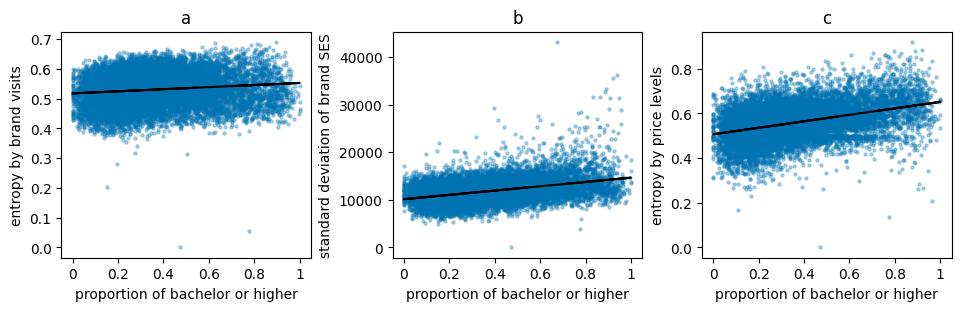

In [ ]:
dt.plot_edu_diversity(edu_diversity)
# plt.savefig('Appendix/FigureE4.png', dpi = 300)

# by industry (naics 3 digits)

In [10]:
selected_brand_cat3d = pd.read_csv('selected_brand_cat3d.csv')

## get some category stats

In [11]:
# industry brand SES and price level variations
cat_stats = selected_brand_cat3d[['brands', 'naics3_category']].merge(brand_median, on = 'brands')
cat_stats = cat_stats.merge(yelp_labelled, on = 'brands')
cat_stats = cat_stats.set_index('brands').groupby('naics3_category').std()
# number of brands in each industry
cat_stats.insert(0, 'nbrands', selected_brand_cat3d.groupby('naics3_category').size())

In [12]:
cat_stats

,nbrands,median,yelp_dollar
naics3_category,,,
"Amusement, Gambling, and Recreation Industries",89,19314.471711,1.035098
Clothing and Clothing Accessories Stores,203,19654.028515,0.767948
Food Services and Drinking Places,297,18584.819774,0.663137
Food and Beverage Stores,95,30776.039034,0.640352
Gasoline Stations,35,20154.446354,0.512348
General Merchandise Stores,42,21078.248891,0.935088
Health and Personal Care Stores,47,14221.484991,0.493548
Miscellaneous Store Retailers,49,23878.609468,0.598017
Motion Picture and Video Industries,9,21571.987287,NaN


## three measures in each cat to report in paper
excluding Personal and Laundry Services(812) and Rental and Leasing Services(532) due to limited number of brands

In [13]:
industries = cat_stats[cat_stats['nbrands'] > 5].index.values

In [14]:
def naics3_matrix(naics3_category):
    """"""
    naics3_brands = selected_brand_cat3d['brands'][selected_brand_cat3d['naics3_category'] == naics3_category]
    matrix = selected_cbg_brand[selected_cbg_brand.columns.intersection(naics3_brands)]
    return matrix

def naics3_diversity(naics3_category):
    """"""
    matrix = naics3_matrix(naics3_category)
    diversity = dt.get_3diversity(matrix)
    return diversity

def naics3_corr_table(cbg_var, variable):
    """"""
    # create an empty dataframe to be filled in 
    columns = ['naics3_category', 'entropy_brand', 'brand_std', 'entropy_price']
    cat_diverstiy = pd.DataFrame(columns = columns)
    significance_levels = [.05, .01, .001]


    for cat in industries:
        # get the diversity measures
        df = naics3_diversity(cat)
        df = df.merge(cbg_var, left_index = True, right_index = True)

        # statistical significance denoted in asterisks
        row = [cat]
        # dealing with one exception 
        measures = ['entropy_brand', 'brand_std'] if cat == "Motion Picture and Video Industries" else ['entropy_brand', 'brand_std', 'entropy_price']
        for measure in measures:
            filtered_df = df.dropna(subset=[measure])
            r, p = stats.pearsonr(filtered_df[variable], filtered_df[measure])
            p_value_sign = ''.join(['*' for t in significance_levels if p <= t])
            value = f"{r.round(3)}{p_value_sign}"
            row.append(value)
        if cat ==  "Motion Picture and Video Industries":
            row.append("-")

        cat_diverstiy.loc[len(cat_diverstiy)] = row
    
    cat_diverstiy = cat_diverstiy.set_index('naics3_category')
    return cat_diverstiy

In [15]:
cat_edu_div = naics3_corr_table(selected_cbg_edu, "bachelor_or_higher")

In [16]:
# merge to report
cat_edu_div.columns = pd.MultiIndex.from_product([['Association with education'], cat_edu_div.columns])
cat_stats.columns = pd.MultiIndex.from_product([['Industry characteristics'], cat_stats.columns])

cat_div_report = cat_edu_div.merge(cat_stats, left_index = True, right_index = True)
cat_div_report = cat_div_report.sort_values(by = [("Association with education","entropy_brand")], ascending = False)

In [17]:
cat_div_report

Association with education  \
                                                                entropy_brand   
naics3_category                                                                 
Amusement, Gambling, and Recreation Industries                       0.278***   
Clothing and Clothing Accessories Stores                             0.142***   
Food Services and Drinking Places                                    0.141***   
Miscellaneous Store Retailers                                         0.13***   
Sporting Goods, Hobby, Musical Instrument, and ...                   0.107***   
Motion Picture and Video Industries                                    0.046*   
Health and Personal Care Stores                                      0.034***   
General Merchandise Stores                                          -0.154***   
Gasoline Stations                                                    -0.12***   
Food and Beverage Stores                                            -0.064***   

                                                                            \
                                                   brand_std entropy_price   
naics3_category                                                              
Amusement, Gambling, and Recreation Industries      0.218***      0.082***   
Clothing and Clothing Accessories Stores            0.049***      0.223***   
Food Services and Drinking Places                   0.347***       0.43***   
Miscellaneous Store Retailers                         0.1***         0.013   
Sporting Goods, Hobby, Musical Instrument, and ...  0.143***      0.079***   
Motion Picture and Video Industries                    0.015             -   
Health and Personal Care Stores                     0.084***      0.089***   
General Merchandise Stores                          0.055***      0.112***   
Gasoline Stations                                   -0.09***     -0.071***   
Food and Beverage Stores                            0.035***        -0.001   

                                                   Industry characteristics  \
                                                                    nbrands   
naics3_category                                                               
Amusement, Gambling, and Recreation Industries                           89   
Clothing and Clothing Accessories Stores                                203   
Food Services and Drinking Places                                       297   
Miscellaneous Store Retailers                                            49   
Sporting Goods, Hobby, Musical Instrument, and ...                       53   
Motion Picture and Video Industries                                       9   
Health and Personal Care Stores                                          47   
General Merchandise Stores                                               42   
Gasoline Stations                                                        35   
Food and Beverage Stores                                                 95   

                                                                              
                                                          median yelp_dollar  
naics3_category                                                               
Amusement, Gambling, and Recreation Industries      19314.471711    1.035098  
Clothing and Clothing Accessories Stores            19654.028515    0.767948  
Food Services and Drinking Places                   18584.819774    0.663137  
Miscellaneous Store Retailers                       23878.609468    0.598017  
Sporting Goods, Hobby, Musical Instrument, and ...  25145.632958    0.592132  
Motion Picture and Video Industries                 21571.987287         NaN  
Health and Personal Care Stores                     14221.484991    0.493548  
General Merchandise Stores                          21078.248891    0.935088  
Gasoline Stations                                   20154.446354    0.512348  
Food a

In [ ]:
# cat_div_report.to_excel("Appendix/TableE1.xlsx")

# NYC vs other

## get different matrices

In [18]:
NYC_codes = ['36005', '36047', '36061', '36081', '36085']
# get the first 5 numbers of the strings
cbg5strings = selected_cbg_brand.index.astype(str).str.slice(0,5)
# nyc cbg to all poi
nyc_all = selected_cbg_brand[cbg5strings.isin(NYC_codes)]
# non-nyc cbg to all poi
nnyc_all = selected_cbg_brand[cbg5strings.isin(NYC_codes) == False]

In [19]:
# get the poi in NYC or not
def unpack_to_matrix(unpack):
    """"""
    matrix = unpack.drop(['placekey', 'city'], axis = 1)
    matrix = matrix.groupby(['visitor_home_cbgs', 'brands']).sum().unstack()
    matrix = matrix.fillna(0)
    matrix.columns = matrix.columns.droplevel(0)
    matrix.index.name = 'cbg'
    matrix.index = matrix.index.astype(int)
    
    return matrix

def get_all2_matrices():
    """"""
    # get poi city data
    NY_brands = pd.read_csv('NY_brands.csv')
    cbg_unpack = pd.read_csv('cbg_unpack.csv')
    POI_city = NY_brands[['placekey', 'city']]
    # merge city with unpack data (poi-cbg pairs)
    unpack_city = pd.merge(cbg_unpack, POI_city, on = 'placekey')
    # select brands and cbgs in our sample
    unpack_city = unpack_city[unpack_city['brands'].isin(selected_brands['brands'])]
    unpack_city = unpack_city[unpack_city['visitor_home_cbgs'].isin(selected_cbg_brand.index.values.astype(str))]
    # select poi-brand pair based on NYC or not
    NYC_unpack = unpack_city[unpack_city['city'] == "New York"]
    nNYC_unpack = unpack_city[unpack_city['city'] != "New York"]
    # get the matrices
    all_nyc = unpack_to_matrix(NYC_unpack)
    all_nnyc = unpack_to_matrix(nNYC_unpack)
    return all_nyc, all_nnyc

In [ ]:
all_nyc, all_nnyc = get_all2_matrices()

In [ ]:
# nyc to nyc
cbg5strings = all_nyc.index.astype(str).str.slice(0,5)
nyc_nyc = all_nyc[cbg5strings.isin(NYC_codes)]

# nnyc to nnyc
cbg5strings = all_nnyc.index.astype(str).str.slice(0,5)
nnyc_nnyc = all_nnyc[cbg5strings.isin(NYC_codes) == False]

## get diversity measures

In [ ]:
def nyc_corr_table(cbg_var, variable):

    matrices = [nyc_all, nyc_nyc, nnyc_all, nnyc_nnyc]

    # create an empty dataframe to be filled in 
    measures = ['entropy_brand', 'brand_std', 'entropy_price']
    nyc_div_report = pd.DataFrame(columns = measures)
    significance_levels = [.05, .01, .001]

    for matrix in matrices:
        df = dt.get_3diversity(matrix)
        df = df.merge(cbg_var, left_index = True, right_index = True)
        row = []
        for measure in measures:
            filtered_df = df.dropna(subset=[measure])
            r, p = stats.pearsonr(filtered_df[variable], filtered_df[measure])
            p_value_sign = ''.join(['*' for t in significance_levels if p <= t])
            value = f"{r.round(3)}{p_value_sign}"
            row.append(value)
        
        nyc_div_report.loc[len(nyc_div_report)] = row

    # set index values
    nyc_div_report.index = ["nyc_all", "nyc_nyc", "nnyc_all", "nnyc_nnyc"]
    return nyc_div_report

In [ ]:
nyc_div_edu = nyc_corr_table(selected_cbg_edu, "bachelor_or_higher")

In [ ]:
nyc_div_edu

,entropy_brand,brand_std,entropy_price
nyc_all,-0.155***,0.171***,0.262***
nyc_nyc,0.287***,0.089***,0.103***
nnyc_all,0.309***,0.494***,0.498***
nnyc_nnyc,0.211***,0.49***,0.47***


In [ ]:
# nyc_div_edu.to_excel("Appendix/TableE2.xlsx")